# Get reading from image using OpenCV-Python
Wrote by Lei Lei</br>
Faculty of Engineering, University of Nottingham

In [1]:
import cv2
import numpy as np

Rescale and extract frames from video.

In [4]:
def rescaleFrame(frame, scale = 0.4):
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    dimensions = (width, height)
    
    return cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)

In [8]:
# Reading Video
capture=cv2.VideoCapture('90C.MOV')
count = 0
success = True
fps = int(capture.get(cv2.CAP_PROP_FPS))

while success:
    success, image = capture.read()
#     print('read a new frame:', success)
    if count%(1*fps) == 0 :
        image = rescaleFrame(image)
        cv2.imwrite('./90C/frame%d.jpg'%count,image)
#         print('successfully written 1th frame')
    count+=1

In [1]:
# Import Packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
mpl.rcParams['image.cmap'] = 'gray'

Input image directory, make output directory, load image.

In [2]:
image_path=r'test.jpg'
out_folder='outs'
os.makedirs(out_folder,exist_ok=True)
image=cv2.imread(image_path)

Reshape and crop the image to save computation efforts.

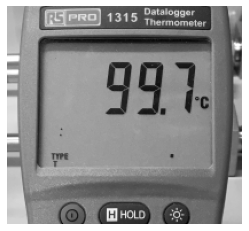

In [3]:
def crop(img, width=500, y=140, h=330, x=125, w=330):
    img=imutils.resize(img, width=500)
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    new_image = img[y:h, x:w]
    cv2.imwrite("Images/new_image.jpg", new_image)
    plt.axis('off')
    plt.imshow(new_image)
    return new_image
new_image=crop(image)

Make a binary image from the cropped image.

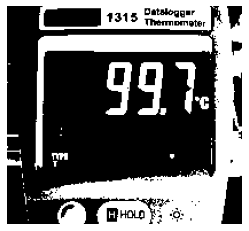

In [5]:
def make_bin(img, gmin=180, gmax=255):
    # Thresholding the image
    (thresh, img_bin) = cv2.threshold(new_image,gmin, gmax, cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin
    cv2.imwrite("Images/Image_bin.jpg", img_bin)
    plt.axis('off')
    plt.imshow(img_bin)
    return img_bin
img_bin=make_bin(new_image)

Set up the parameters to find horizontal and vertical lines.

In [6]:
# Defining a kernel length
kernel_length = np.array(new_image).shape[1]//150
# print(kernel_length)
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

Get lines with the above parameters.

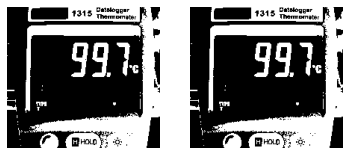

In [7]:
def get_lines(img, verticle_kernel, hori_kernel):
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("Images/verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    cv2.imwrite("Images/horizontal_lines.jpg",horizontal_lines_img)
    plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    plt.imshow(verticle_lines_img);
    plt.axis('off')

    plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')
    return verticle_lines_img, horizontal_lines_img

verticle_lines_img, horizontal_lines_img = get_lines(img_bin, verticle_kernel = verticle_kernel, hori_kernel = hori_kernel)

Set up parameters to combine the vertical lines and horizontal lines images.

In [8]:
alpha = 0.5
beta = 1.0 - alpha

Combine the vertical lines and horizontal lines images

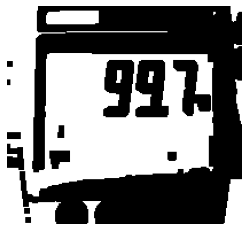

In [9]:
def combine(img1, img2, alpha, beta):
    """Combine the horizontal and vertical lines
    alpha and beta are weighting parameters, this will decide the quantity of an image to be added to make a new image."""
    img_final_bin = cv2.addWeighted(img1, alpha, img2, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt.axis('off')
    plt.imshow(img_final_bin)
    return img_final_bin

img_final_bin=combine(verticle_lines_img, horizontal_lines_img, alpha = alpha, beta = beta)

Sort the contours from the combined lines image.

In [10]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

Get by the contours find by the width and length characteristics of the reading:</br>
w > 20 and h > 20, and 0.8\*h > w > 0.5\*h

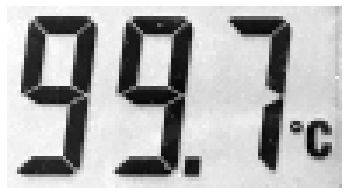

In [11]:
def get_reading(img, contours):
    xpos=[]
    ypos=[]
    wlist=[]
    hlist=[]
    for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # If a box height is greater then 20 & widht is greater then 20, add it's position info in the empty lists.
        if (w > 20 and h > 20) and 0.8*h > w > 0.5*h:
            xpos.append(x)
            ypos.append(y)
            wlist.append(w)
            hlist.append(h)
    new_img = img[np.array(ypos).min():np.array(ypos).min()+np.array(hlist).max(), np.array(xpos).min():np.array(xpos).max()+np.array(wlist).max()]
    plt.imshow(new_img)
    plt.axis('off')
    cv2.imwrite(os.path.join(out_folder, f'temp_{image_path}'), new_img)

get_reading(new_image,contours=contours)